# Introduction - Fandango's movie rating investigation

Fandango is an online movie ratings aggregator. In 2015, a data Journalist named Walt Hickey investigated the movie ratings that were hosted on Fandango and found inconsistencies between the displayed rating, and the actual rating (Which he had found inside the HTML of the page). 

Note that the rating system has since been replaced with a completely different system entirely. For the purpose of the project, I'll be referencing the older, star rating system.

![image info](https://s3.amazonaws.com/dq-content/288/s1gp_fdg_stars.png)

He had found that:

- ratings were almost always rounded up to the nearest half-star, e.g. 4.1 to 4.5 (as opposed to 4)
- some were also rated from a half-star to a full-star abritrarily, e.g. 4.5 to 5
- other inconsistencies were found; movies rated 4 were rounded up to 5 with no apparent reason

The team at FiveThirtyEight also shown that:

![image info](https://s3.amazonaws.com/dq-content/288/s1gp_actual_vs_displayed.png)

From the results above, we can determine that:
- both distributions are left-skewed, meaning ratings are generally high
- no ratings below 2 stars

Fandango's official stance is that the rounding was based on a bug instead of being an intentional feature. This project will aim to investigate Fandango movie ratings from more recent data to determine if there has been any change since Hickey's analysis. 

My aim will be to analyse data **prior** to Hickey's 2015 data, comparing it to data from 2016 and 2017. 

# Exploratory steps

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def explore(dataset):
    print(dataset.info())
    print(dataset.head())

In [3]:
#read in data
pre_hickey = pd.read_csv('fandango_score_comparison.csv')
post_hickey = pd.read_csv('movie_ratings_16_17.csv')

In [4]:
explore(pre_hickey)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
FILM                          146 non-null object
RottenTomatoes                146 non-null int64
RottenTomatoes_User           146 non-null int64
Metacritic                    146 non-null int64
Metacritic_User               146 non-null float64
IMDB                          146 non-null float64
Fandango_Stars                146 non-null float64
Fandango_Ratingvalue          146 non-null float64
RT_norm                       146 non-null float64
RT_user_norm                  146 non-null float64
Metacritic_norm               146 non-null float64
Metacritic_user_nom           146 non-null float64
IMDB_norm                     146 non-null float64
RT_norm_round                 146 non-null float64
RT_user_norm_round            146 non-null float64
Metacritic_norm_round         146 non-null float64
Metacritic_user_norm_round    146 non-null float64
IMDB_norm_round               146 n

In [5]:
explore(post_hickey)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
movie           214 non-null object
year            214 non-null int64
metascore       214 non-null int64
imdb            214 non-null float64
tmeter          214 non-null int64
audience        214 non-null int64
fandango        214 non-null float64
n_metascore     214 non-null float64
n_imdb          214 non-null float64
n_tmeter        214 non-null float64
n_audience      214 non-null float64
nr_metascore    214 non-null float64
nr_imdb         214 non-null float64
nr_tmeter       214 non-null float64
nr_audience     214 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB
None
                     movie  year  metascore  imdb  tmeter  audience  fandango  \
0      10 Cloverfield Lane  2016         76   7.2      90        79       3.5   
1                 13 Hours  2016         48   7.3      50        83       4.5   
2      A Cure for Wellness  2016     

In [6]:
#isolating columns of interest
pre_hickey = pre_hickey[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]
post_hickey = post_hickey[['movie', 'year', 'fandango']]

In [7]:
pre_hickey.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [8]:
post_hickey.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


### Observations -  determining statistical method

The **population** of interest is the movie ratings stored on Fandango's website. The population is **sampled** into two different time periods: before Hickey's analysis, and after Hickey's analysis. 

**The sampling criteria**

Based on the readme files, the sampling criteria for Hickey's **original data** was:

- movie had at least 30 ratings at time of sampling
- had tickets on sale during time of sampling

The sampling therefore wasn't random, and may not be representative of the population as the sampling was done in 2015 alone. 

For post_hickey data, the sampling is:

- movie released in 2016 or 2017
- must have considerable number of votes and reviews (not stated in readme)

Therefore, the type of sampling in both is **subjective sampling**. Because of this I have two options:
1. collect new data
2. change analysis goal, place limitations on it


### New analysis goal - differences between ratings for popular movies in 2015 and 2016

This gives two populations of interest:
1. ratings for popular movies in 2015
2. ratings for popular movies in 2016

My **criteria** will be movies with at least 30 fan ratings (as with Hickey's original critera).

However, one of the datasets doesn't provide information about the number of fan ratings. To check how representative they are, i'll sample 10 random samples and check the number of fan ratings manually on Fandango's website.

In [9]:
#checking how representative samples are

#using 1 as random state seed
post_hickey.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


All movies had 30 or more movies ratings, according to the search on Fandango.

### Data cleaning - isolating correct years
Now I'll isolate only movies that were released in 2015 and 2016 into separate data sets. The pre_hickey dataset does not have a year column. Instead, the year is saved into the title of the movie. I'll extract this first and year a new column to save the results.

In [10]:
#making year column for pre_hickey dataset first
pre_hickey['year'] = pre_hickey['FILM'].str[-5:-1]

In [11]:
#checking number of entries in years
pre_hickey['year'].value_counts()

2015    129
2014     17
Name: year, dtype: int64

In [12]:
#isolating only 2015 movies - year was saved as str 
pre_hickey_2015 = pre_hickey[pre_hickey['year'] == '2015']

In [13]:
pre_hickey_2015['year'].value_counts()

2015    129
Name: year, dtype: int64

In [14]:
#doing the same for post_hickey data
post_hickey['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [15]:
post_hickey_2016 = post_hickey[post_hickey['year'] == 2016]

In [16]:
post_hickey_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

# Data analysis - comparing distribution with kernel density plots

In [17]:
post_hickey_2016.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0


In [18]:
pre_hickey_2015.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


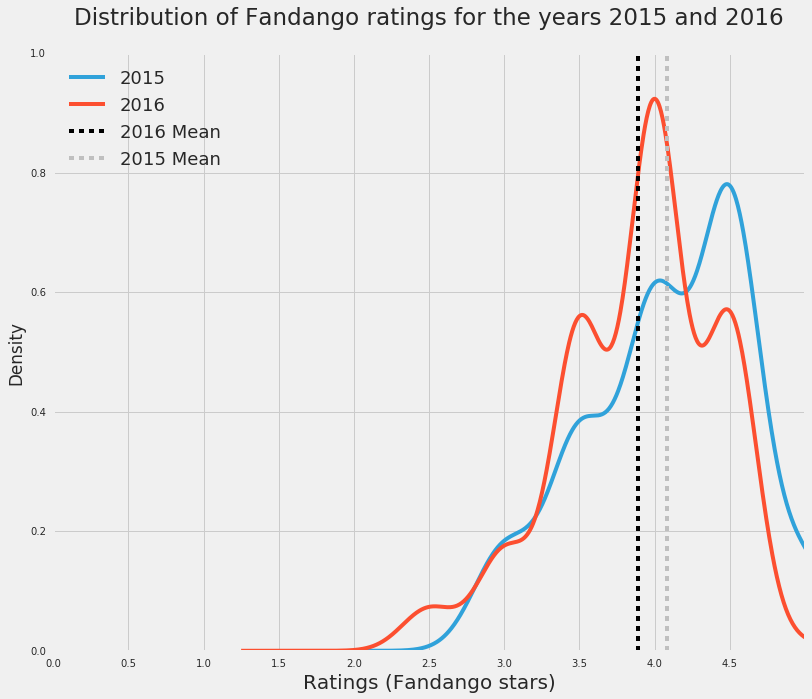

In [48]:
#use fivethirtyeight style
plt.style.use('fivethirtyeight')


#adding means
mean_2016 = post_hickey_2016['fandango'].mean()
mean_2015 = pre_hickey_2015['Fandango_Stars'].mean()

#plotting kdes
plt.figure(figsize=(12,10))
pre_hickey_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True)
post_hickey_2016['fandango'].plot.kde(label = '2016', legend = True)
plt.title('Distribution of Fandango ratings for the years 2015 and 2016', size=23, y = 1.04)


#plotting means 
plt.axvline(x = mean_2016, dashes = (5, 5), color = '0',
            label = '2016 Mean')
plt.axvline(x = mean_2015, dashes = (5, 5), color = '0.75',
            label = '2015 Mean')

plt.legend(loc=2, prop={'size': 18})
#as ratings go from 0 to 5
plt.xlim(0,5)
plt.xlabel('Ratings (Fandango stars)', size = 20)
plt.xticks(np.arange(0, 5, step=0.5))
plt.show()

### Observations

In terms of **shape**, both plots are left-skewed, heavily in favour of high rating values.
- both ratings are comparable, however 2016 ratings show a slightly less degree of skew
- suggests that ratings were lower in 2016

Therefore, the direction of difference in ratings for the year 2016 is slightly lower than that of 2015. 

# Data analysis - comparing frequency distributions
In order to delve deeper into the frequency distributions, i'll analyse more granular information. I'll now compare the frequency distributions tables. Because the samples have quite a difference in the number of movies, i'll compare percentages for improved readability. 

In [20]:
#calculating percentage of each movie rating
print('2015')
print(pre_hickey_2015['Fandango_Stars'].value_counts(normalize = True) * 100)
print('\n 2016')
print(post_hickey_2016['fandango'].value_counts(normalize = True) * 100)
    

2015
4.5    37.984496
4.0    28.682171
3.5    17.829457
3.0     8.527132
5.0     6.976744
Name: Fandango_Stars, dtype: float64

 2016
4.0    40.314136
4.5    24.607330
3.5    24.083770
3.0     7.329843
2.5     3.141361
5.0     0.523560
Name: fandango, dtype: float64


### Observations
- lowest rating in 2016 is 2.5, whereas in 2015 it was 3.0 - a difference of 0.5
- in 2015, there was 7% of scores awarded 5.0 stars, compared with only 0.5% in 2016
- higher scores were awarded more frequently in the 2015 data, compared to the 2016 data

# Data analysis - producing summary statistics
After confirming the two data sets have a difference in distribution, i'll calculate some summary statistics to more clearly highlight the direction of the difference between them. I'll do this by computing the mean, median and mode for each dataset, then comparing them using a grouped bar plot.

In [21]:
mean_2015 = pre_hickey_2015['Fandango_Stars'].mean()
mean_2016 = post_hickey_2016['fandango'].mean()
means = [mean_2015, mean_2016]

mode_2015 = pre_hickey_2015['Fandango_Stars'].mode()[0]
mode_2016 = post_hickey_2016['fandango'].mode()[0]

median_2015 = pre_hickey_2015['Fandango_Stars'].median()
median_2016 = post_hickey_2016['fandango'].median()

In [22]:
summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


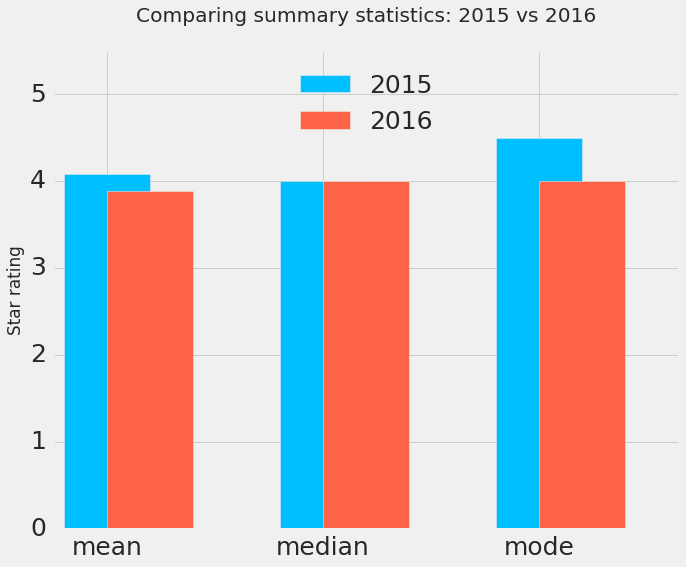

In [23]:
summary['2015'].plot.bar(color = 'deepskyblue', figsize=(10,8), rot=0, align = 'center', width = .4)
summary['2016'].plot.bar(color = 'tomato', figsize=(10,8), rot=0, align = 'edge', width = .4)
plt.title('Comparing summary statistics: 2015 vs 2016', y=1.05)
plt.ylim(0,5.5)
plt.tick_params(labelsize=25)
plt.ylabel('Star rating')

plt.legend(loc = 9, fontsize=25)
plt.show()

# Conclusion
From the results of the analysis, popular movies released in 2015 received a higher Fandango rating than popular movies relased in 2016. 

Based on the fact that Fandango has since replaced the rating system with Rotten Tomato's percentage score, the difference may have been due to an intentional rounding bias that Fandango used. 